In [1]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


In [3]:
# file_id = '1HdGi3mgpPlGnRwP-aWTSnp70BRNPaNVA'
file_id = '1Z9evWwUK4nTpARz67ZWraNe5sX2MNcFx'
destination = '/content/dataset.zip'
download_file_from_google_drive(file_id, destination)

In [4]:
!unzip -q dataset.zip
!rm -rf dataset.zip

In [5]:
test_file_id_1 = '1bIr_ikTxGuuZnJulykXeZz04pyb27S3f'
test_destination_1 = '/content/test1.zip'
download_file_from_google_drive(test_file_id_1, test_destination_1)

In [6]:
!unzip -q test1.zip
!rm -rf test1.zip

In [7]:
test_file_id_2 = '1Kj0QsxJ1m0n0UCPiaFskskUhM7fvxqS4'
test_destination_2 = '/content/test2.zip'
download_file_from_google_drive(test_file_id_2, test_destination_2)

In [8]:
!unzip -q test2.zip
!rm -rf test2.zip

In [9]:
# All images are supposed to be the same size, say, N*L
IMAGE_DIR = "/content/train_small"

In [10]:
from __future__ import division
import os
import numpy as np
import scipy.stats as ss
import cv2
import matplotlib.pyplot as plt
import fnmatch
import re
import collections

In [11]:
def getClassFromName(fileName,lastSubdir=True):
        if lastSubdir:
            name = os.path.basename(os.path.dirname(fileName))
        else:
            name = os.path.basename(fileName)
        mat = re.match(".*(\d+).*", name)
        if mat != None:
            return int(mat.group(1))
        else:
            return name.__hash__()

In [12]:
image_names = []
image_dictionary = []

image_1D = []
for root, dirnames, filenames in os.walk(IMAGE_DIR):
    for filename in fnmatch.filter(filenames, "*.*"):
        image_names.append(os.path.join(root, filename))
for idx,image_name in enumerate(image_names):
    img = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE).astype(np.float64)
    if idx == 0:
        # the shape of the image. They are sopposed to be the same
        imgShape = img.shape
        # the normalized image matrix. it will be normalized by subtracting from the average image later
        vector_matrix = np.zeros((imgShape[0]*imgShape[1], len(image_names)),dtype=np.float64)
    #img = cv2.pyrDown(img)
    image_dictionary.append((image_name,img,getClassFromName(image_name)))
    image_1D.append(img.flatten())
    # vector_matrix[:,idx] = img.flatten()

print(image_dictionary)

[('/content/train_small/s18/5.pgm', array([[122., 120., 121., ..., 113., 116., 112.],
       [122., 120., 117., ..., 115., 114., 113.],
       [121., 123., 122., ..., 112., 118., 114.],
       ...,
       [ 92.,  85.,  89., ...,  69.,  64.,  68.],
       [ 87.,  90.,  88., ...,  62.,  67.,  59.],
       [ 88.,  85.,  91., ...,  59.,  67.,  58.]]), 8), ('/content/train_small/s18/2.pgm', array([[122., 120., 125., ..., 118., 112., 113.],
       [125., 121., 121., ..., 113., 115., 112.],
       [120., 119., 120., ..., 117., 112., 115.],
       ...,
       [ 89.,  86.,  88., ...,  65.,  67.,  63.],
       [ 91.,  88.,  85., ...,  67.,  66.,  62.],
       [ 92.,  91.,  87., ...,  65.,  62.,  66.]]), 8), ('/content/train_small/s18/8.pgm', array([[121., 120., 122., ..., 116., 113., 112.],
       [120., 121., 119., ..., 115., 115., 114.],
       [120., 122., 120., ..., 115., 114., 115.],
       ...,
       [ 87.,  94.,  94., ...,  67.,  67.,  66.],
       [ 91.,  89.,  92., ...,  64.,  65.,  67

In [13]:
# print(image_1D)  # 92x112
print(len(image_1D))

160


Calculating the normalized image vectors.

In [14]:
mean = []
a_transpose_norm = []
for i in range(len(image_1D[0])):
  mean.append(0)

  for j in range(len(image_1D)):
    mean[i] += image_1D[j][i]/len(image_1D)
    # print(sum)

for i in range(len(image_1D)):
  a_transpose_norm.append([])
  for j in range(len(mean)):
    a_transpose_norm[i].append(image_1D[i][j] - mean[j])
    # print(a_transpose_norm)

# print(len(a_transpose_norm))

In [15]:
a_norm = np.transpose(a_transpose_norm)  #A
len(a_norm)

10304

Calculating eigenvectors and eigenvalues of the covariance matrix formed by the image vectors.

In [16]:
cov_matrix = np.cov(a_transpose_norm) # At*A
# print(cov_matrix)
len(cov_matrix[0])

160

In [17]:
### returns eigen values and then all eigen vectors
eigen = np.linalg.eig(cov_matrix)
# for i in range(len(eigen)):
#   print(eigen[i])
v_eigenvalues=eigen[0]
v=np.transpose(eigen[1])
# print(v_eigenvalues)
# print(v)
# print(len(v), len(v[0]))


In [18]:
u_transpose = []
for i in range(len(v)):
  array = np.matmul(a_norm,v[i])
  u_transpose.append(array)
u=np.transpose(u_transpose)
# print(len(u),len(u[0]))
print(len(u), len(u[0]))

10304 160


In [19]:
eigen_values = eigen[0]
eigen_vectors=eigen[1]
# print(eigen_values)
eigen_d = {}
for i in range(len(eigen_values)):
  eigen_d[eigen_values[i]]=i
eigen_d

{43219.953977553596: 0,
 18749.895990890815: 1,
 17942.155464146246: 2,
 12061.802455045403: 3,
 10489.25912953686: 4,
 8066.724722559026: 5,
 7297.85172164008: 6,
 6261.016588366359: 7,
 5873.753178029104: 8,
 4420.5004066534: 9,
 3826.304473465676: 10,
 3579.8886501814827: 11,
 3112.701941552233: 12,
 2932.3449009364517: 13,
 2747.3196034473535: 14,
 2487.396345846331: 15,
 2411.0446487988524: 16,
 2252.6641238208167: 17,
 2074.7096367875374: 18,
 1989.9475765463246: 19,
 1928.8795510110008: 20,
 1773.305425328178: 21,
 1676.8247434736688: 22,
 1640.8845693566923: 23,
 1586.0134088610828: 24,
 1384.3119343572707: 25,
 1360.5249845839646: 26,
 1272.8354997100732: 27,
 1171.4911399813118: 28,
 1150.5295704016391: 29,
 1117.2277311946657: 30,
 1066.7345849297926: 31,
 1027.8242127649535: 32,
 1000.5604997800493: 33,
 957.4881339639342: 34,
 932.1908536264845: 35,
 890.6505933876211: 36,
 -5.107739735450283e-13: 37,
 867.9216091629972: 38,
 833.6071838643115: 39,
 806.8325487486294: 40,


Selecting the K eigenvectors of covariance matrix corresponding to the K largest eigenvalues. 

In [20]:
k=12

In [21]:
# sorting the dictionary of eigenvalues to get the corresponding eigenvectors.
from collections import OrderedDict
dict1 = OrderedDict(sorted(eigen_d.items(),reverse=True))
dict2=dict(dict1)
print(dict2)

{43219.953977553596: 0, 18749.895990890815: 1, 17942.155464146246: 2, 12061.802455045403: 3, 10489.25912953686: 4, 8066.724722559026: 5, 7297.85172164008: 6, 6261.016588366359: 7, 5873.753178029104: 8, 4420.5004066534: 9, 3826.304473465676: 10, 3579.8886501814827: 11, 3112.701941552233: 12, 2932.3449009364517: 13, 2747.3196034473535: 14, 2487.396345846331: 15, 2411.0446487988524: 16, 2252.6641238208167: 17, 2074.7096367875374: 18, 1989.9475765463246: 19, 1928.8795510110008: 20, 1773.305425328178: 21, 1676.8247434736688: 22, 1640.8845693566923: 23, 1586.0134088610828: 24, 1384.3119343572707: 25, 1360.5249845839646: 26, 1272.8354997100732: 27, 1171.4911399813118: 28, 1150.5295704016391: 29, 1117.2277311946657: 30, 1066.7345849297926: 31, 1027.8242127649535: 32, 1000.5604997800493: 33, 957.4881339639342: 34, 932.1908536264845: 35, 890.6505933876211: 36, 867.9216091629972: 38, 833.6071838643115: 39, 806.8325487486294: 40, 774.5620675914377: 41, 758.6272156532845: 42, 738.4342113595159: 43,

In [22]:
# indexes of of k maximum eigenvalues
index_list=[]
for e in dict2:
  if(len(index_list)>=k):
    break
  index_list.append(dict2[e])
print(index_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [23]:
# eigenvectors of k maximum eigenvalues
u_k=[]
for i in index_list:
  u_k.append(u_transpose[i])
print(u_k)

[array([-250.34987268, -246.96739775, -251.03150872, ...,   62.66394197,
         42.95102603,   -7.43283506]), array([-293.03400587, -296.61765524, -294.39034777, ...,  -50.55568765,
        -45.94985846,  -50.66399445]), array([ 69.73691919,  64.22732671,  68.583571  , ..., -41.61421501,
       -40.95085605, -38.69027747]), array([ 15.24047245,  19.31637724,  22.9986019 , ..., -81.3522821 ,
       -68.21885398, -73.1093675 ]), array([   7.04373461,    4.56640216,    2.24472334, ..., -102.02376868,
        -80.93066914,  -59.14922928]), array([-64.63035609, -68.56599373, -60.92922784, ...,  97.30812891,
        83.50398642,  56.29972771]), array([-73.39842816, -75.85858873, -75.10925541, ..., -21.30720511,
       -25.49241544,   5.10502217]), array([  76.33460672,   78.27079323,   83.86525799, ..., -100.27234286,
        -77.988847  ,  -61.0207666 ]), array([-103.25654954, -100.23979122,  -96.30983044, ...,  -37.3388256 ,
        -49.91948021,  -28.46092446]), array([-62.26684061, -59

Plotting the mean vector.

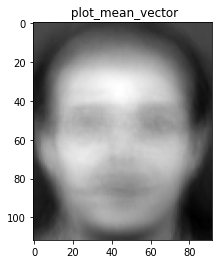

In [24]:
fig,axarr = plt.subplots()
axarr.set_title(" plot_mean_vector")
avg_image = np.reshape(mean, (imgShape))
axarr.imshow(avg_image, cmap=plt.cm.gray)

Plotting the k eigenfaces.

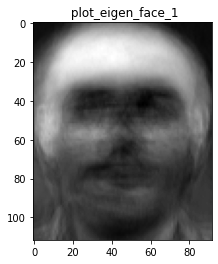

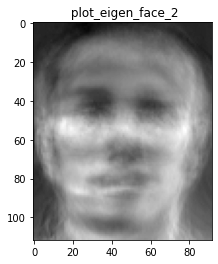

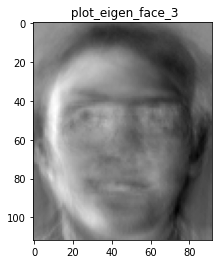

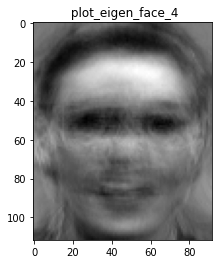

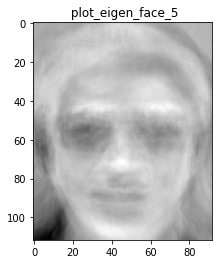

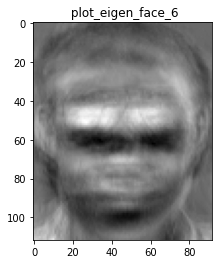

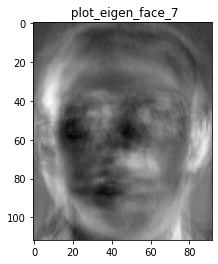

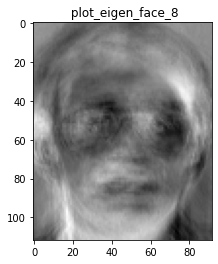

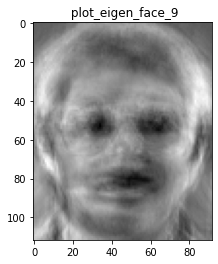

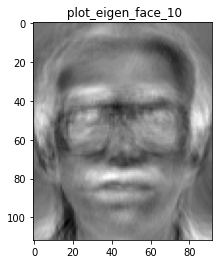

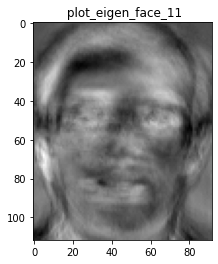

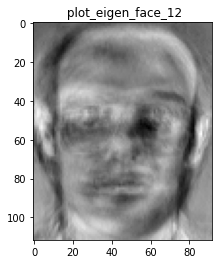

In [25]:
for i in range(k):
  fig,axarr = plt.subplots()
  axarr.set_title(" plot_eigen_face_"+str(i+1))
  avg_image = np.reshape(u_k[i], (imgShape))
  axarr.imshow(avg_image, cmap=plt.cm.gray)

Projecting the image vector onto the eigenvector space for the training images.

In [26]:
#storing the weights of each training image in an array.
w_array=[]
for i in range(len(cov_matrix[0])):
  w=np.linalg.lstsq(np.transpose(u_k),np.transpose(a_transpose_norm[i]))
  w_array.append(w[0])
print(len(w_array), len(w_array[0]))
# w_array

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


160 12


**Testing the algorithm.**

Run this after uploading a suitable PGM file to the colab runtime.

In [27]:
# calculating the k weights of the testing image.
test_input_dir = '/content/test2/21.10.pgm'

img = (cv2.imread(test_input_dir, cv2.IMREAD_GRAYSCALE).astype(np.float64))
img2 = cv2.resize(img, (92,112)).flatten()
test_norm = []
for j in range(len(mean)):
    test_norm.append(img2[j] - mean[j])
    
w_test = np.linalg.lstsq(np.transpose(u_k),np.transpose(test_norm))
# w[0]
w_test[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # Remove the CWD from sys.path while we load stuff.


array([-0.07443157, -0.05199043, -0.03452918,  0.00588262, -0.06525574,
        0.05910174,  0.02300715, -0.1146693 ,  0.01696625,  0.12576575,
       -0.03781769,  0.06760834])

Generating the output image by the weigted average of all eigenvectors. 

In [28]:
test_out = np.zeros([10304,1])
# print(len(test_out),len(test_out[0]) )
# print(len(eigen_vectors) , len(eigen_vectors[1]))

for i in range(10304):
  for j in range(k):
    test_out[i]+=u_k[j][i]*w_test[0][j]
  # temp = np.multiply(eigen_vectors[i], w[0][i])
  # test_out = np.add(test_out,temp)

test_out
# print(len(test_out) , len(test_out[1]))

array([[ 5.71813978],
       [ 6.27467914],
       [ 5.75108127],
       ...,
       [48.65214524],
       [39.88628419],
       [39.06759262]])

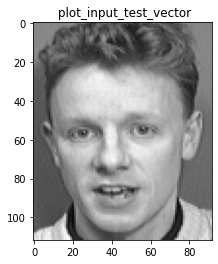

In [29]:
fig,axarr = plt.subplots()
axarr.set_title(" plot_input_test_vector")
avg_image = np.reshape(img2, (imgShape))
axarr.imshow(avg_image, cmap=plt.cm.gray)

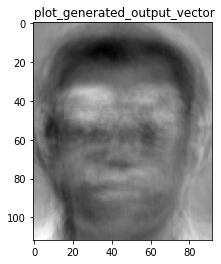

In [30]:
fig,axarr = plt.subplots()
axarr.set_title(" plot_generated_output_vector")
avg_image = np.reshape(test_out, (imgShape))
axarr.imshow(avg_image, cmap=plt.cm.gray)

Calculating error and finding out the most similar face in the training dataset that matches the given test image.

In [31]:
# print(w_array)
# print(w_list)
# w[0]
err_list=[]
err_ind=-1
for i in range(len(w_array)):
  err_list.append(np.linalg.norm(w_array[i]-w_test[0]))
print(min(err_list))
for i in range(len(err_list)):
  if err_list[i]==min(err_list):
    err_ind = i
    print(err_ind)
# print(sorted(err_list))

0.18143765852048863
65


**Testing the algorithm**

In [32]:
r=0
for idx,image_name in enumerate(image_names):
    
    if r==err_ind:
      print(image_name)
      similar_image = image_name
      name = image_name[18:20]
      if name[-1] == '/':
       name = name[0]
      # print(int(name))
    r=r+1 

/content/train_small/s15/2.pgm


In [33]:
img_sim = (cv2.imread(similar_image, cv2.IMREAD_GRAYSCALE).astype(np.float64))
img_similar = cv2.resize(img_sim, (92,112)).flatten()

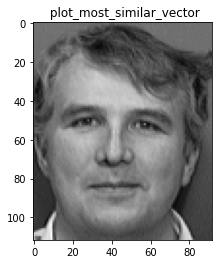

In [34]:
fig,axarr = plt.subplots()
axarr.set_title(" plot_most_similar_vector")
avg_image = np.reshape(img_similar, (imgShape))
axarr.imshow(avg_image, cmap=plt.cm.gray)

Accuracy calculation on the test dataset.


In [35]:
IMAGE_DIR_TEST = '/content/test1'
image_names_test = []
image_dictionary_test = []

image_1D_test = []
for root, dirnames, filenames in os.walk(IMAGE_DIR_TEST):
    for filename in fnmatch.filter(filenames, "*.*"):
        image_names_test.append(os.path.join(root, filename))
for idx,image_name in enumerate(image_names_test):
    img = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE).astype(np.float64)
    if idx == 0:
        imgShape = img.shape
    image_dictionary_test.append((image_name,img,getClassFromName(image_name)))
    image_1D_test.append(img.flatten())
a_transpose_norm_test = []

for i in range(len(image_1D_test)):
  a_transpose_norm_test.append([])
  for j in range(len(mean)):
    a_transpose_norm_test[i].append(image_1D_test[i][j] - mean[j])
w_array_test=[]
for i in range(len(image_1D_test)):
  w=np.linalg.lstsq(np.transpose(u_k),np.transpose(a_transpose_norm_test[i]))
  w_array_test.append(w[0])
print(len(w_array_test), len(w_array_test[0]))
err_ind_test=[]
errors=[]
for i in range(len(image_1D_test)):
  err_list_test=[]
  for j in range(len(image_1D)):
    err_list_test.append(np.linalg.norm(w_array[j]-w_array_test[i]))
  for k in range(len(err_list_test)):
    if err_list_test[k]==min(err_list_test):
      err_ind_test.append(k)
  errors.append(min(err_list_test))
  # print(min(err_list_test))
print(err_ind_test)
print(errors)
print(min(errors), max(errors))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


40 12
[93, 30, 18, 99, 83, 132, 69, 10, 55, 36, 37, 110, 123, 99, 153, 85, 44, 3, 44, 99, 154, 123, 74, 146, 7, 21, 56, 8, 88, 136, 65, 24, 112, 136, 55, 110, 5, 76, 57, 127]
[0.0757127465319844, 0.10885643270758318, 0.09982672432289147, 0.22965267358321398, 0.09663999294457895, 0.10747999023965292, 0.055989675997151954, 0.16283310445990043, 0.14024121457987115, 0.08898125784699758, 0.1091917765266306, 0.0421484701167536, 0.13195768691294044, 0.10475370669325086, 0.10345169369490421, 0.07871307828956393, 0.12175428724950767, 0.11715511620447168, 0.11937662312615109, 0.11984501287376065, 0.1837596768150345, 0.20196556808851845, 0.0657074177531883, 0.06459352913082324, 0.11651594954608181, 0.0658201048666385, 0.10880310269229757, 0.16724841426724457, 0.09996120926750159, 0.03269611984829349, 0.05048778170214982, 0.08773380517183153, 0.18297053305111705, 0.12392150772000826, 0.12214481272783141, 0.0843174151116105, 0.09381321355844549, 0.06815983554787529, 0.08350351134064858, 0.112618860

In [36]:
IMAGE_DIR_TEST = '/content/test2'

In [37]:
image_names_test = []
image_dictionary_test = []

image_1D_test = []
for root, dirnames, filenames in os.walk(IMAGE_DIR_TEST):
    for filename in fnmatch.filter(filenames, "*.*"):
        image_names_test.append(os.path.join(root, filename))
for idx,image_name in enumerate(image_names_test):
    img = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE).astype(np.float64)
    if idx == 0:
        # the shape of the image. They are sopposed to be the same
        imgShape = img.shape
        # the normalized image matrix. it will be normalized by subtracting from the average image later
    #img = cv2.pyrDown(img)
    image_dictionary_test.append((image_name,img,getClassFromName(image_name)))
    image_1D_test.append(img.flatten())

# print(image_dictionary_test)

In [38]:
# print(image_1D)  # 92x112
print(len(image_1D_test))

40


In [39]:
a_transpose_norm_test = []

for i in range(len(image_1D_test)):
  a_transpose_norm_test.append([])
  for j in range(len(mean)):
    a_transpose_norm_test[i].append(image_1D_test[i][j] - mean[j])
    # print(a_transpose_norm)

# print(len(a_transpose_norm))

In [40]:
#storing the weights of each training image in an array.
w_array_test=[]
for i in range(len(image_1D_test)):
  w=np.linalg.lstsq(np.transpose(u_k),np.transpose(a_transpose_norm_test[i]))
  w_array_test.append(w[0])
print(len(w_array_test), len(w_array_test[0]))
# w_array_test

40 12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


In [41]:
err_ind_test2=[]
errors2=[]
for i in range(len(image_1D_test)):
  err_list_test=[]
  for j in range(len(image_1D)):
    err_list_test.append(np.linalg.norm(w_array[j]-w_array_test[i]))
  for k in range(len(err_list_test)):
    if err_list_test[k]==min(err_list_test):
      err_ind_test2.append(k)
  errors2.append(min(err_list_test))
  # print(min(err_list_test))
print(err_ind_test2)
print(errors2)
print(min(errors2), max(errors2))

[70, 80, 64, 64, 142, 139, 98, 67, 74, 70, 136, 24, 94, 53, 23, 78, 3, 65, 74, 64, 18, 29, 26, 64, 148, 136, 43, 29, 64, 19, 64, 26, 69, 145, 157, 67, 98, 65, 66, 25]
[0.24455933614674108, 0.21225727440574949, 0.21483738113923947, 0.2264812212568616, 0.19503708762652225, 0.21052439930504327, 0.21937298516722972, 0.20007678390656794, 0.18103627681490483, 0.25375188437646584, 0.1898239623952792, 0.2095789084573638, 0.16793299966164493, 0.15377921146663465, 0.21237820988615969, 0.15129736285049772, 0.19429071916624643, 0.22181699853680736, 0.2172953972464706, 0.1851673660516963, 0.18568749015993063, 0.16346036514447684, 0.17130978526360258, 0.25363554542627026, 0.14079092639207766, 0.18591898763766568, 0.20677666448000173, 0.17019033105945425, 0.24572292568018825, 0.22270775040965246, 0.20489410866428956, 0.20714207572106164, 0.14314830244653792, 0.15424412868661652, 0.21356987051130216, 0.17955444373324905, 0.21084554196768995, 0.18143765852048863, 0.21813505783692944, 0.1551079094804947

In [42]:
tp=0
tn=0
fp=0
fn=0
threshold = (min(errors) + max(errors))/2

for i in range(len(errors)):
  if errors[i] > threshold :
    fn+=1
  elif errors[i] <= threshold:
    tp+=1 

for i in range(len(errors2)):
  if errors2[i] > threshold :
    tn+=1
  elif errors2[i] <= threshold:
    fp+=1 

incorrect_classifications = fp+fn
print(incorrect_classifications)

8
